In [1]:
%load_ext autoreload
%autoreload 2

#expr_path = '/home/sbanerjee/Documents/work/sparse-regression/gradvi-experiments/dsc/functions'
expr_path = '/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/gradvi-experiments/dsc/functions'

import numpy as np
import sys
sys.path.append(expr_path)
import simulate

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from mrashpen.utils import R_lasso
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models import mixture_gaussian as mix_gauss
from gradvi.inference import LinearRegression
from gradvi.priors import Ash

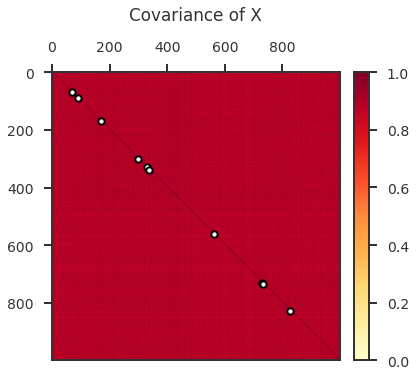

In [3]:
rholist = [0.9, 0.9]
ntrain  = 200
ntest   = 1000
npred   = 1000
pcausal = 10
min_block_size = 100
pve = 0.6
signal = "normal"
bfix = None

X, y, Xtest, ytest, btrue, strue = \
    simulate.linear_model(
        ntrain, npred, pcausal, pve, ntest = ntest,
        corr_method = 'equicorr', rho = rholist, min_block_size = min_block_size,
        signal = signal, bfix = bfix, #signal_params = {'loc': 10},
        seed = None)

bidx = np.where(btrue != 0)[0]

def plot_covariance(x):
    
    covx = np.cov(x.T, bias = True)

    fig = plt.figure(figsize = (6, 6))
    ax1 = fig.add_subplot(111)

    cmap1 = matplotlib.cm.get_cmap("YlOrRd").copy()
    cmap1.set_bad("w")

    norm1 = matplotlib.colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
    im1 = ax1.imshow(covx.T, cmap = cmap1, norm = norm1, interpolation='nearest', origin = 'upper')
    # im1 = ax1.matshow(covx, cmap = cmap1, norm = norm1)
    ax1.tick_params(bottom = False, top = True, left = True, right = False,
                    labelbottom = False, labeltop = True, labelleft = True, labelright = False)

    ax1.scatter(bidx, bidx, s = 40, edgecolor = 'black', facecolor = 'white', lw = 2)


    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)
    ax1.set_title("Covariance of X", pad = 20)
    plt.tight_layout()
    plt.show()
    
plot_covariance(X)

In [4]:
X.shape

(200, 1000)

In [5]:
Xtest.shape

(1000, 1000)

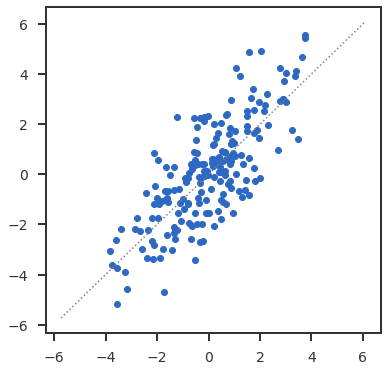

In [6]:
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, btrue), y)
mpl_utils.plot_diag(ax1)
plt.show()

In [8]:
k = 20

In [9]:
def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk = np.abs((np.power(scale, np.arange(k) / k) - 1))
    return w, sk

wk, sk = initialize_ash_prior(k, scale = 2)

In [10]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

R[write to console]: Loading required package: Matrix



Lasso initialization


In [11]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

Mr.ASH terminated at iteration 136.


In [12]:
'''
GradVI
'''
prior = Ash(sk, wk = winit, scaled = True)
gv1 = LinearRegression()
# gv1.fit(X, y, prior, b_init = lasso_b, s2_init = s2init)
gv1.fit(X, y, prior, s2_init = None)

In [13]:
'''
GradVI
'''
prior = Ash(sk, wk = winit, scaled = True)
gv2 = LinearRegression()
gv2.fit(X, y, prior, b_init = lasso_b, s2_init = s2init)

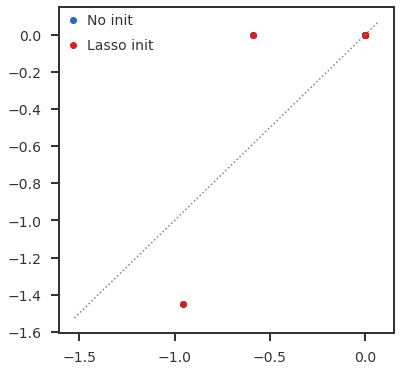

In [14]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(mrash_r.coef, gv1.coef, label = "No init")
ax1.scatter(mrash_r.coef, gv2.coef, label = "Lasso init")
ax1.legend()
mpl_utils.plot_diag(ax1)
plt.show()

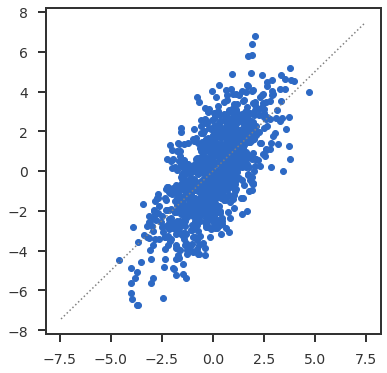

In [16]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(Xtest, gv2.coef), ytest)
mpl_utils.plot_diag(ax1)
plt.show()

In [17]:
gv2.intercept

0.0854832365258185

In [18]:
mrash_r.intercept

0.08548323652581839

In [19]:
gv1_mse = np.mean(np.square(ytest - np.dot(Xtest, gv1.coef) - gv1.intercept))
gv2_mse = np.mean(np.square(ytest - np.dot(Xtest, gv2.coef) - gv2.intercept))
mrash_r_mse = np.mean(np.square(ytest - np.dot(Xtest, mrash_r.coef) - mrash_r.intercept))
true_mse = np.mean(np.square(ytest - np.dot(Xtest, btrue)))

print ("MSE =>")
print ("No init", gv1_mse / true_mse)
print ("Lasso init", gv2_mse / true_mse)
print ("Mr.ASH", mrash_r_mse / true_mse)
print ("True", true_mse / true_mse)

MSE =>
No init 1.203038104912028
Lasso init 1.2031174543725136
Mr.ASH 1.1767324902066818
True 1.0


In [20]:
true_mse

1.9260748964290564

In [21]:
np.square(strue)

1.757497434166576

In [22]:
gv1_cmse = np.mean(np.square(btrue - gv1.coef))
gv2_cmse = np.mean(np.square(btrue - gv2.coef))
mrash_r_cmse = np.mean(np.square(btrue - mrash_r.coef))
true_cmse = np.mean(np.square(btrue - btrue))

print ("Coef MSE =>")
print ("No init", gv1_cmse)
print ("Lasso init", gv2_cmse)
print ("Mr.ASH", mrash_r_cmse)

Coef MSE =>
No init 0.004498445854180353
Lasso init 0.004499350239859517
Mr.ASH 0.00378169732127916


In [23]:
np.sqrt(gv1.residual_var)

1.4517466785708146

In [24]:
gv1.niter

186

In [25]:
gv2.niter

180

In [26]:
mrash_r.niter

136

In [27]:
mrash_r.elbo_path

array([377.08339061, 375.08407869, 374.66239175, 374.41300233,
       374.18569444, 374.0225847 , 373.92251428, 373.86165528,
       373.82153155, 373.79265477, 373.77045668, 373.752595  ,
       373.73776167, 373.72516511, 373.71429134, 373.70478639,
       373.69639465, 373.68892457, 373.68222835, 373.67618937,
       373.67071398, 373.66572584, 373.66116204, 373.65697016,
       373.6531062 , 373.64953292, 373.64621862, 373.6431361 ,
       373.64026197, 373.63757592, 373.63506033, 373.63269975,
       373.63048064, 373.62839105, 373.62642039, 373.62455927,
       373.62279929, 373.62113293, 373.61955344, 373.61805472,
       373.61663126, 373.61527805, 373.61399053, 373.61276453,
       373.61159625, 373.61048218, 373.60941909, 373.60840401,
       373.60743419, 373.60650708, 373.60562031, 373.60477168,
       373.60395913, 373.60318076, 373.60243477, 373.60171948,
       373.60103333, 373.60037484, 373.59974264, 373.59913541,
       373.59855193, 373.59799105, 373.59745169, 373.59

In [36]:
mrash_r.fitobj.keys()

dict_keys(['beta', 'sigma2', 'pi', 'iter', 'varobj', 'intercept', 'data', 'update.order'])

In [39]:
mrash_r.fitobj['pi']

array([9.97521885e-01, 2.20797913e-06, 4.73961640e-12, 2.28094440e-12,
       1.70900130e-12, 1.79718053e-12, 2.35497278e-12, 3.60678357e-12,
       7.38763574e-12, 2.98655093e-08, 2.24770095e-05, 6.59528810e-04,
       1.39137925e-03, 3.80081941e-04, 2.20081948e-05, 3.98790586e-07,
       3.06077215e-09, 1.93480671e-11, 5.18039304e-12, 3.99504742e-12])

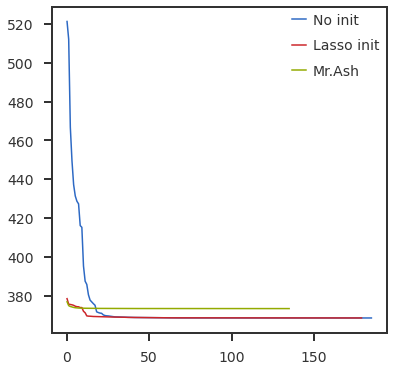

In [28]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(gv1.niter), gv1.elbo_path, label = "No init")
ax1.plot(np.arange(gv2.niter), gv2.elbo_path, label = "Lasso init")
ax1.plot(np.arange(mrash_r.niter), mrash_r.elbo_path, label = "Mr.Ash")
ax1.legend()
#mpl_utils.plot_diag(ax1)
plt.show()

In [29]:
gv2.elbo_path[-1]

368.76837731042997

In [30]:
gv1.elbo_path[-1]

368.75644282030635

In [31]:
gv1.obj_path[-1]

-2280.4022404537113

In [32]:
gv2.obj_path[-1]

-2280.3903059635877

In [33]:
from gradvi.models import LinearModel
model = LinearModel(
    gv1._X, gv1._y, gv1.coef, gv1.residual_var, gv1.prior,
    dj = gv1._dj, objtype = 'direct', debug = True)
model.objective

2022-07-08 16:30:26,536 | gradvi.models.linear_model               | DEBUG   | Calculating Linear Model objective with ash_scaled prior
2022-07-08 16:30:26,537 | gradvi.models.linear_model               | DEBUG   | Residual variance = 2.107568418741392


-2280.40224048682

In [34]:
from gradvi.models import LinearModel
mrash_prior = Ash(sk, wk = mrash_r.prior)
model = LinearModel(
    gv1._X, gv1._y, gv2.coef, gv2.residual_var, mrash_prior,
    dj = gv1._dj, objtype = 'direct', debug = True)
model.objective

2022-07-08 16:30:40,013 | gradvi.models.linear_model               | DEBUG   | Calculating Linear Model objective with ash_scaled prior
2022-07-08 16:30:40,013 | gradvi.models.linear_model               | DEBUG   | Residual variance = 2.109646737591671


-2279.347720636719

In [26]:
dir(gv1)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_c_fun',
 '_dj',
 '_elbo_path',
 '_h_path',
 '_init_params',
 '_intercept',
 '_invert_method',
 '_invert_options',
 '_is_debug',
 '_is_elbo_calc',
 '_is_f_fortran',
 '_is_intercept',
 '_is_lbfgsb_fortran',
 '_is_opt_list',
 '_method',
 '_nclbk',
 '_nfev',
 '_niter',
 '_njev',
 '_objtype',
 '_opts',
 '_prior',
 '_res',
 '_v2inv',
 '_y',
 'callback',
 'coef',
 'elbo_path',
 'fit',
 'fit_fortran',
 'fit_python',
 'fitobj',
 'fun',
 'get_elbo',
 'get_model_func',
 'get_new_model',
 'grad',
 'initialize_params',
 'intercept',
 'logger',
 'nfev',
 'niter',
 'njev',
 'obj_path',
 'prior',
 'residual_var',
 'success',
 't